In [331]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [332]:
from pathlib import Path
from PIL import Image
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        try:
            with Image.open(filepath) as img:
                img_type = img.format.lower()
                if img_type is None:
                    print(f"{filepath} is not an image")
                    os.remove(filepath)
                elif img_type not in img_type_accepted_by_tf:
                    print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
                    os.remove(filepath)

        except (IOError, OSError) as e:
            print(f"Error opening {filepath}: {e}")

In [333]:
from tensorflow import keras

image_size = (64, 64)
batch_size = 32

class_names = ["Curly_Hair", "Straight_Hair", "Wavy_Hair"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
)

Found 985 files belonging to 3 classes.
Using 788 files for training.
Found 985 files belonging to 3 classes.
Using 197 files for validation.


In [334]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['Curly_Hair', 'Straight_Hair', 'Wavy_Hair']


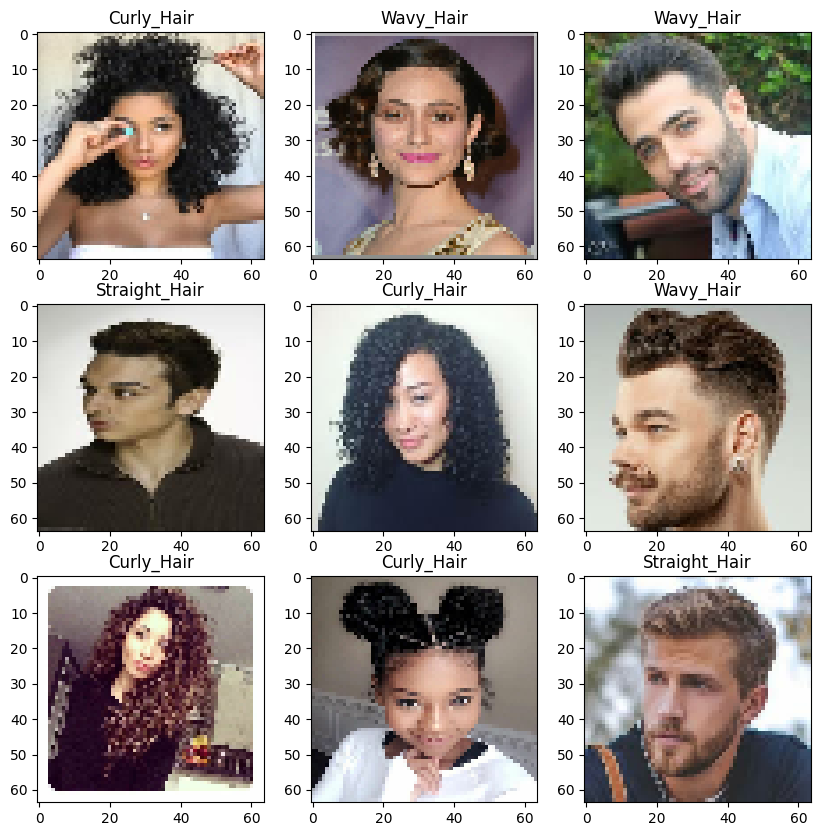

In [335]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i]).numpy()])
    plt.show()

In [336]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(factor=0.2),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ]
)

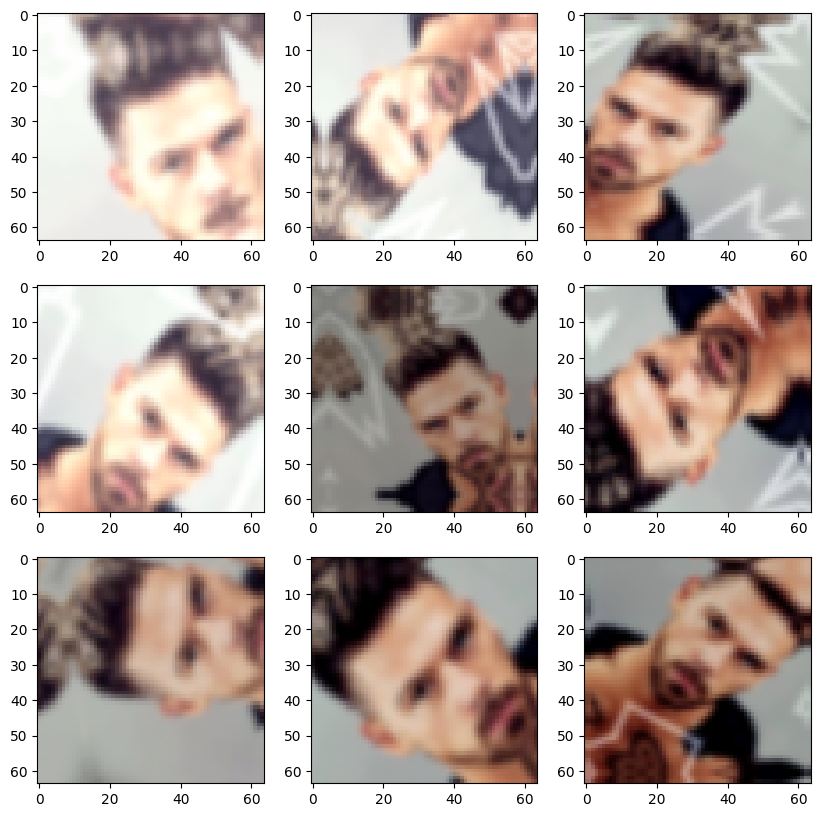

In [337]:
sample_images = train_ds.take(1)
for images, _ in sample_images:
    sample_image = images[0]
    break

# Reshape the image for data augmentation
image = tf.expand_dims(sample_image, 0)
image = tf.cast(image, tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(augmented_image).numpy().astype("uint8"))

plt.show()

In [338]:
AUTOTUNE = tf.data.AUTOTUNE


def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [339]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

In [340]:
image_size = (64, 64)

model = Sequential(
    [
        layers.Input(shape=image_size + (3,)),
        layers.Rescaling(1.0 / 255),
        layers.Conv2D(4, kernel_size=16, strides=1, padding="valid", dilation_rate=1),
        layers.Activation("relu"),
        layers.Conv2D(8, kernel_size=8, strides=1, padding="valid", dilation_rate=1),
        layers.Activation("relu"),
        layers.Conv2D(16, kernel_size=4, strides=1, padding="valid", dilation_rate=1),
        layers.Activation("relu"),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation="relu"),
        layers.Dense(3, activation="softmax"),
    ]
)

In [341]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

tf.keras.utils.plot_model(model, to_file="model_experiment2.png", show_shapes=True)

model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_29 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_86 (Conv2D)          (None, 49, 49, 4)         3076      
                                                                 
 activation_30 (Activation)  (None, 49, 49, 4)         0         
                                                                 
 conv2d_87 (Conv2D)          (None, 42, 42, 8)         2056      
                                                                 
 activation_31 (Activation)  (None, 42, 42, 8)         0         
                                                                 
 conv2d_88 (Conv2D)          (None, 39, 39, 16)        2064      
                                                                 
 activation_32 (Activation)  (None, 39, 39, 16)      

In [342]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 50

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Fit the model with EarlyStopping callback
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping]
)

Epoch 1/50
25/25 [==============================] - 7s 169ms/step - loss: 1.0997 - accuracy: 0.3274 - val_loss: 1.0994 - val_accuracy: 0.2843
Epoch 2/50
25/25 [==============================] - 6s 170ms/step - loss: 1.0980 - accuracy: 0.3503 - val_loss: 1.0993 - val_accuracy: 0.2843
Epoch 3/50
25/25 [==============================] - 5s 160ms/step - loss: 1.0966 - accuracy: 0.3503 - val_loss: 1.0968 - val_accuracy: 0.2843
Epoch 4/50
25/25 [==============================] - 6s 166ms/step - loss: 1.0927 - accuracy: 0.3553 - val_loss: 1.0964 - val_accuracy: 0.2843
Epoch 5/50
25/25 [==============================] - 5s 153ms/step - loss: 1.0928 - accuracy: 0.3655 - val_loss: 1.0940 - val_accuracy: 0.2893
Epoch 6/50
25/25 [==============================] - 6s 163ms/step - loss: 1.0884 - accuracy: 0.3883 - val_loss: 1.0878 - val_accuracy: 0.3655
Epoch 7/50
25/25 [==============================] - 5s 153ms/step - loss: 1.0775 - accuracy: 0.3972 - val_loss: 1.0868 - val_accuracy: 0.4162
Epoch 

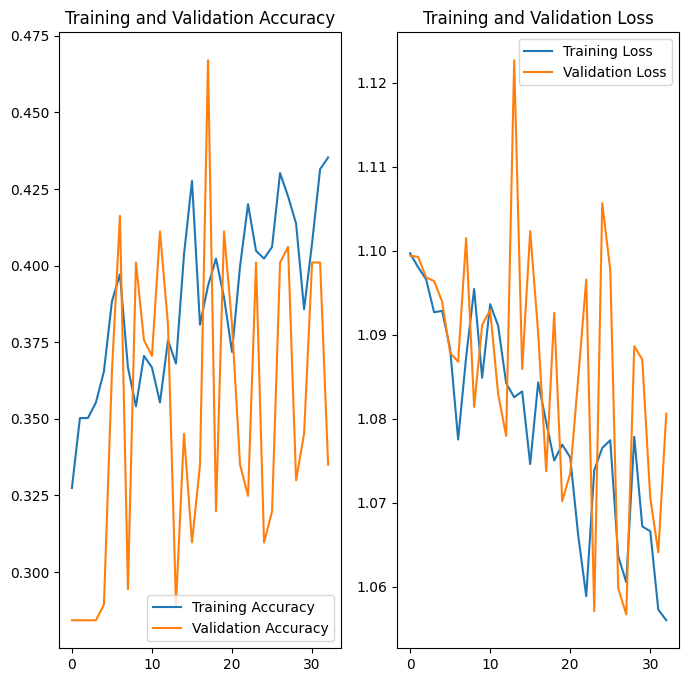

In [343]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [344]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg",
    target_size=image_size,
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)

1/1 [==============================] - 0s 92ms/step
This image is 0.39 percent curly hair, 0.30 percent straight hair, and 0.31 percent wavy hair.
